In [1]:
import numpy as np
import pandas as pd

targets = ['_5HT2A', 'AChE', 'D2R', 'D3R', 'MAOB']
num = [1000, 2000, 5000]

dataframes = {
    target: pd.read_csv(f'../generated_molecules/predicted_activity/{target}.csv')
    for target in targets
}

dataframes["Unconditional"] = pd.read_csv('../generated_molecules/predicted_activity/Unconditional.csv')

for target in dataframes:
    df = dataframes[target]
    col_preds = df.columns[1]

    count_invalid = len(df[df[col_preds] == 'Invalid SMILES'])
    print(f"{target}: {count_invalid}")

    # Drop invalid smiles rows
    dataframes[target] = df[df[col_preds] != 'Invalid SMILES'].copy()
    # Set dtype as float for every column except SMILES
    for col in df.columns:
        if col != 'SMILES':
            dataframes[target][col] = dataframes[target][col].astype(float)

    print(dataframes[target].shape)

_5HT2A: 0
(30000, 7)
AChE: 0
(30000, 7)
D2R: 0
(30000, 11)
D3R: 0
(30000, 7)
MAOB: 0
(30000, 7)
Unconditional: 0
(30000, 17)


In [2]:
aggs = ["SUM", "MEAN", "MAX"]
# aggs = ["MEAN", "MAX"]
# aggs = ["SUM"]

multi_targets = list()

for agg in aggs:
    multi_targets.extend([
        f"AChE_MAOB_{agg}",
        f"D2R__5HT2A_{agg}",
        f"D2R_D3R_{agg}"
    ])

dataframes_mt = {
    targets: pd.read_csv(f'../generated_molecules/predicted_activity/{targets}.csv')
    for targets in multi_targets
}

for mts in dataframes_mt:
    df = dataframes_mt[mts]

    col_preds = df.columns[1]

    count_invalid = len(df[df[col_preds] == 'Invalid SMILES'])
    print(f"{mts}: {count_invalid}")

    # Drop invalid smiles rows
    dataframes_mt[mts] = df[df[col_preds] != 'Invalid SMILES'].copy()
    # Set dtype as float for every column except SMILES
    for col in df.columns:
        if col != 'SMILES':
            dataframes_mt[mts][col] = dataframes_mt[mts][col].astype(float)
    
    print(dataframes_mt[mts].shape)

AChE_MAOB_SUM: 0
(30000, 7)
D2R__5HT2A_SUM: 0
(30000, 7)
D2R_D3R_SUM: 0
(30000, 7)
AChE_MAOB_MEAN: 0
(30000, 7)
D2R__5HT2A_MEAN: 0
(30000, 7)
D2R_D3R_MEAN: 0
(30000, 7)
AChE_MAOB_MAX: 0
(30000, 7)
D2R__5HT2A_MAX: 0
(30000, 7)
D2R_D3R_MAX: 0
(30000, 7)


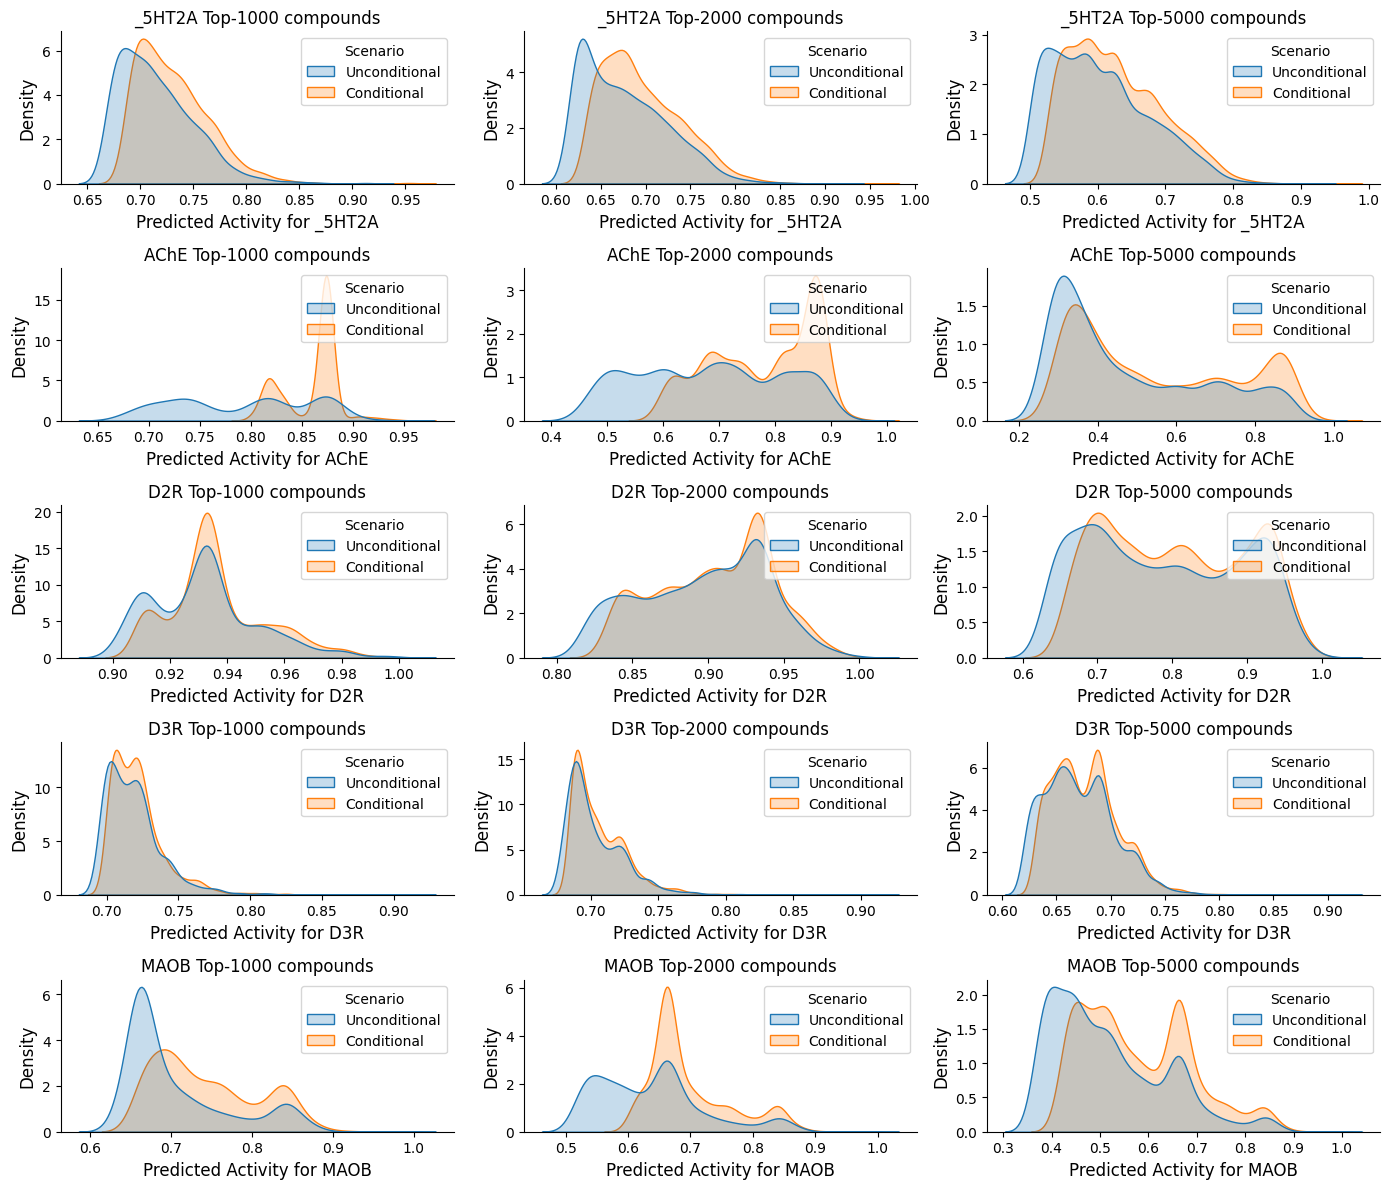

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

ACT_TYPE = "Activity" 
# ACT_TYPE = "pIC50"
# ACT_TYPE = "inhibition"

pal=list(sns.color_palette("tab10"))
fig, axes = plt.subplots(len(targets), len(num), figsize=(14, 12))

for i, name in enumerate(targets):
    for j, n in enumerate(num):
        activity_column = f"{name}_{ACT_TYPE}"
        unconditional = dataframes["Unconditional"][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario="Unconditional")

        conditional = dataframes[name][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario="Conditional")

        activities = pd.concat([unconditional, conditional]).reset_index()

        sns.kdeplot(data=activities, x=activity_column, bw_adjust=1, hue='Scenario',ax=axes[i, j], fill=True)
        # sns.histplot(data=activities, x=activity_column, hue='Scenario',ax=axes[i, j], fill=True)

        axes[i, j].set_title('{} Top-{} compounds'.format(name, n), fontsize=12)
        axes[i, j].spines['right'].set_visible(False)
        axes[i, j].spines['top'].set_visible(False)
        axes[i, j].set_ylabel("Density", fontsize=12)
        axes[i, j].set_xlabel(f"Predicted {ACT_TYPE} for {name}", fontsize=12)

    plt.tight_layout()

plt.show()

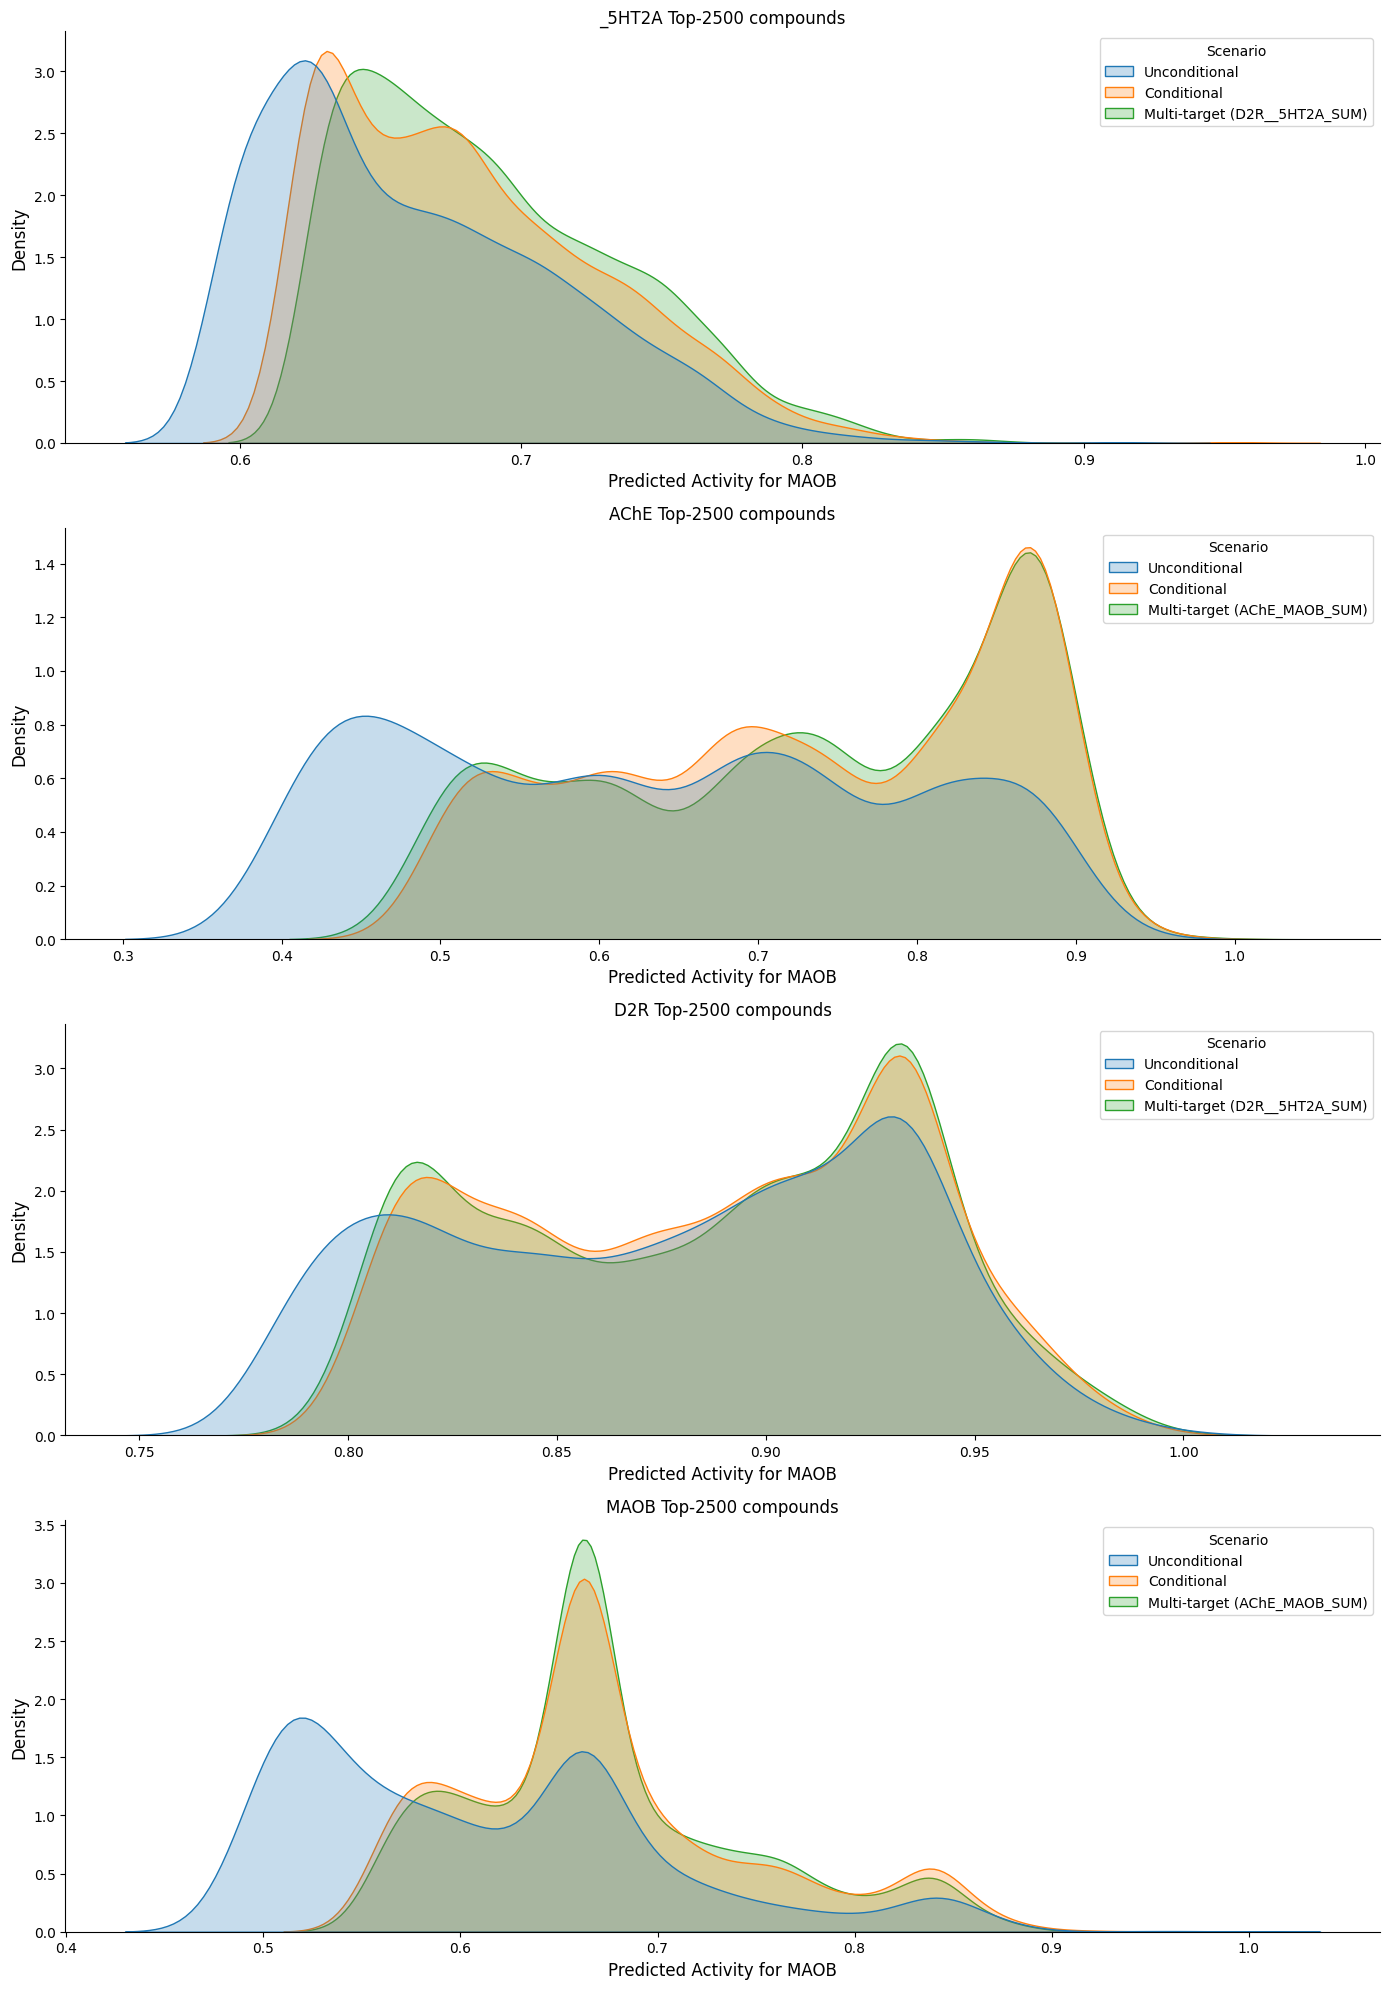

In [4]:
# Plot the multi-target distributions for the top 1000 compounds
agg = "SUM"

multi_targets = [
    f"AChE_MAOB_{agg}",
    f"D2R__5HT2A_{agg}",
    # f"D2R_D3R_{agg}"
]

# targets = ['_5HT2A', 'AChE', 'D2R', 'D3R', 'MAOB']
targets = ['_5HT2A', 'AChE', 'D2R', 'MAOB']
# targets =  ['AChE', 'MAOB']

fig, axes = plt.subplots(len(targets), 1, figsize=(14, 20))
n = 2500

for j, target in enumerate(targets):
    activity_column = f"{target}_{ACT_TYPE}"
    df_list = list()

    unconditional = dataframes["Unconditional"][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Unconditional")

    conditional = dataframes[target][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Conditional")

    df_list.append(unconditional)
    df_list.append(conditional)

    for mts in multi_targets:
        if target not in mts:
            continue
    
        multi_target = dataframes_mt[mts][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario=f'Multi-target ({mts})')

        df_list.append(multi_target)

    activities = pd.concat(df_list).reset_index()

    sns.kdeplot(data=activities, x=activity_column, bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)
    # sns.kdeplot(data=df, x="pred_pXC50", bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)

    axes[j].set_title('{} Top-{} compounds'.format(target, n), fontsize=12)
    axes[j].spines['right'].set_visible(False)
    axes[j].spines['top'].set_visible(False)
    axes[j].set_ylabel("Density", fontsize=12)
    axes[j].set_xlabel(f"Predicted {ACT_TYPE} for {name}", fontsize=12)

plt.tight_layout()
plt.show()

In [5]:
# !pip install ptitprince

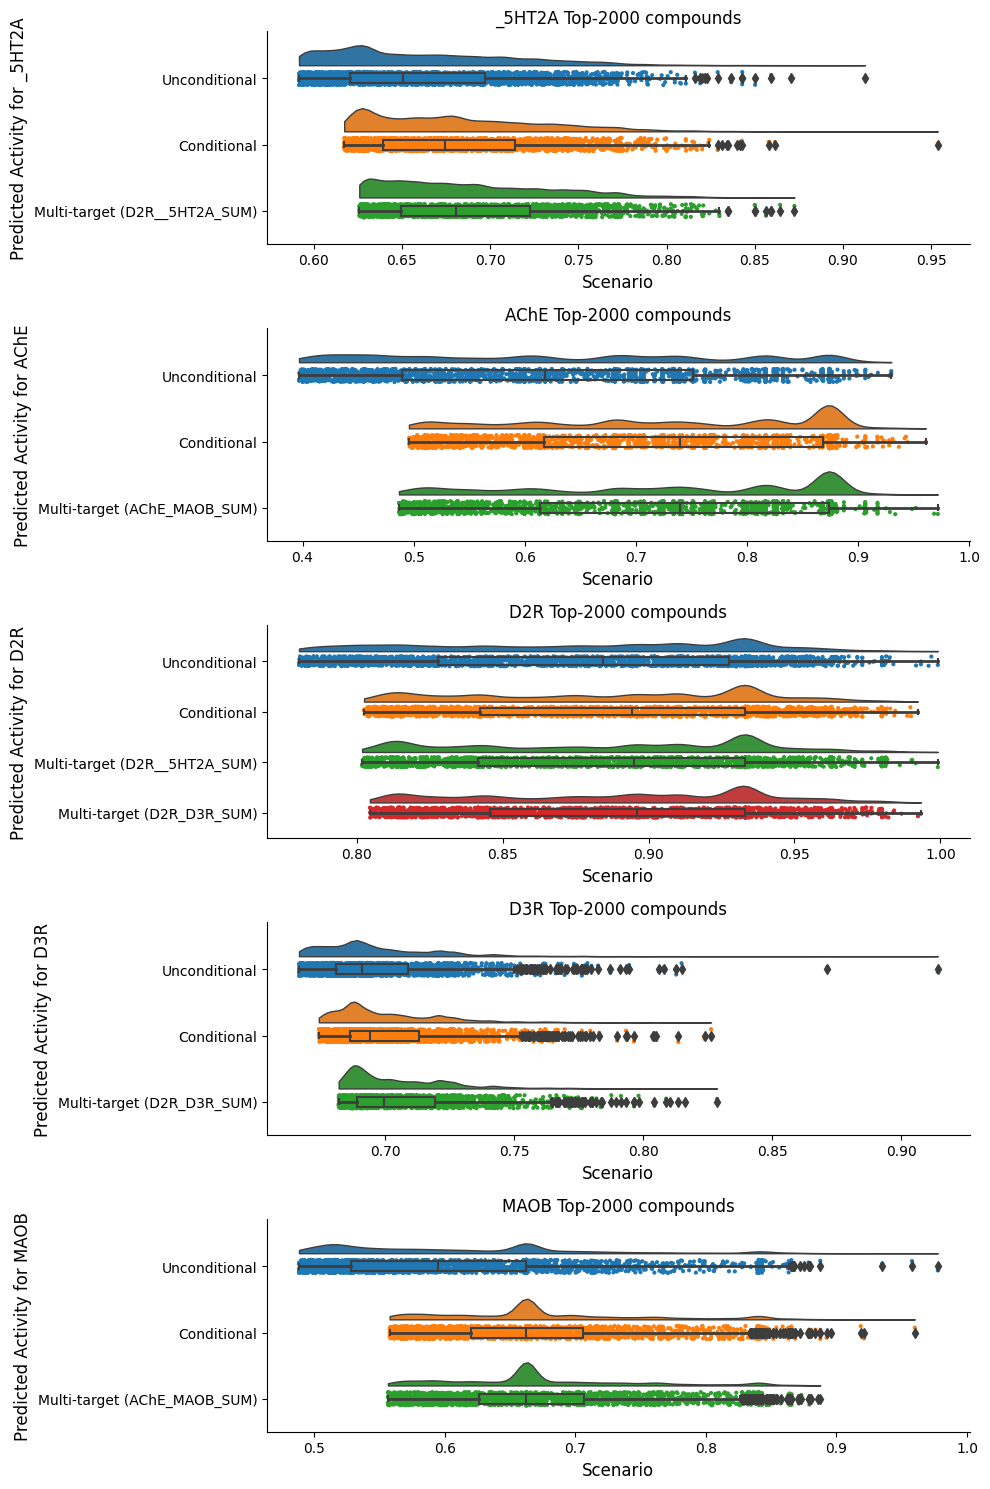

In [6]:
import ptitprince as pt

num = 2000
agg = "SUM"

multi_targets = [
    f"AChE_MAOB_{agg}",
    f"D2R__5HT2A_{agg}",
    f"D2R_D3R_{agg}"
]

targets = ['_5HT2A', 'AChE', 'D2R', 'D3R', 'MAOB']
# targets = ['_5HT2A', 'AChE', 'D2R', 'MAOB']
# targets =  ['AChE', 'MAOB']

fig, axes = plt.subplots(len(targets), figsize=(10, 15))

for i, target in enumerate(targets):
    activity_column = f"{target}_{ACT_TYPE}"
    df_list = list()

    unconditional = dataframes["Unconditional"][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Unconditional")

    conditional = dataframes[target][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Conditional")

    df_list.append(unconditional)
    df_list.append(conditional)

    for mts in multi_targets:
        if target not in mts:
            continue
    
        multi_target = dataframes_mt[mts][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario=f'Multi-target ({mts})')

        df_list.append(multi_target)

    activities = pd.concat(df_list).reset_index()

    pt.RainCloud(data=activities, x='Scenario', y=activity_column, bw=.1, ax=axes[i], palette=pal, orient = "h")

    axes[i].set_title('{} Top-{} compounds'.format(target, num), fontsize=12)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].set_ylabel(f"Predicted {ACT_TYPE} for {target}", fontsize=12)
    axes[i].set_xlabel("Scenario", fontsize=12)

plt.tight_layout()

plt.show()

In [7]:
for j, target in enumerate(targets):
    activity_column = f"{target}_{ACT_TYPE}"
    df_list = list()

    unconditional = dataframes["Unconditional"][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Unconditional")

    conditional = dataframes[target][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Conditional")

    df_list.append(unconditional)
    df_list.append(conditional)

    for mts in multi_targets:
        if target not in mts:
            continue
    
        multi_target = dataframes_mt[mts][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario=f'Multi-target ({mts})')

        df_list.append(multi_target)

    activities = pd.concat(df_list).reset_index()
    pivot = activities.pivot_table(index='Scenario', values=activity_column, aggfunc=[np.mean, np.std])
    format_str = "{:.2%}" if ACT_TYPE == "Activity" else "{:.2f}"

    # print(f"Target: {target}")
    display(pivot.style
                 .format(format_str)
                 .set_caption(f"Top-{n} {target} {ACT_TYPE} statistics")
                 .background_gradient(cmap='Blues', axis=0))

,mean,std
,_5HT2A_Activity,_5HT2A_Activity
Scenario,,
Conditional,68.17%,4.82%
Multi-target (D2R__5HT2A_SUM),68.93%,4.75%
Unconditional,66.18%,5.16%


,mean,std
,AChE_Activity,AChE_Activity
Scenario,,
Conditional,73.04%,12.65%
Multi-target (AChE_MAOB_SUM),72.88%,13.06%
Unconditional,63.23%,15.20%


,mean,std
,D2R_Activity,D2R_Activity
Scenario,,
Conditional,88.70%,4.86%
Multi-target (D2R_D3R_SUM),88.97%,4.76%
Multi-target (D2R__5HT2A_SUM),88.64%,4.95%
Unconditional,87.74%,5.36%


,mean,std
,D3R_Activity,D3R_Activity
Scenario,,
Conditional,70.10%,2.10%
Multi-target (D2R_D3R_SUM),70.58%,2.10%
Unconditional,69.70%,2.29%


,mean,std
,MAOB_Activity,MAOB_Activity
Scenario,,
Conditional,67.37%,7.60%
Multi-target (AChE_MAOB_SUM),67.39%,7.17%
Unconditional,61.08%,9.35%


### Assess mean target modulation

Combination: AChE_MAOB_Activity
Unconditional
AChE
MAOB
AChE_MAOB_SUM
Combination: D2R_D3R_Activity
Unconditional
D2R
D3R
D2R_D3R_SUM
Combination: D2R__5HT2A_Activity
Unconditional
D2R
_5HT2A
D2R__5HT2A_SUM


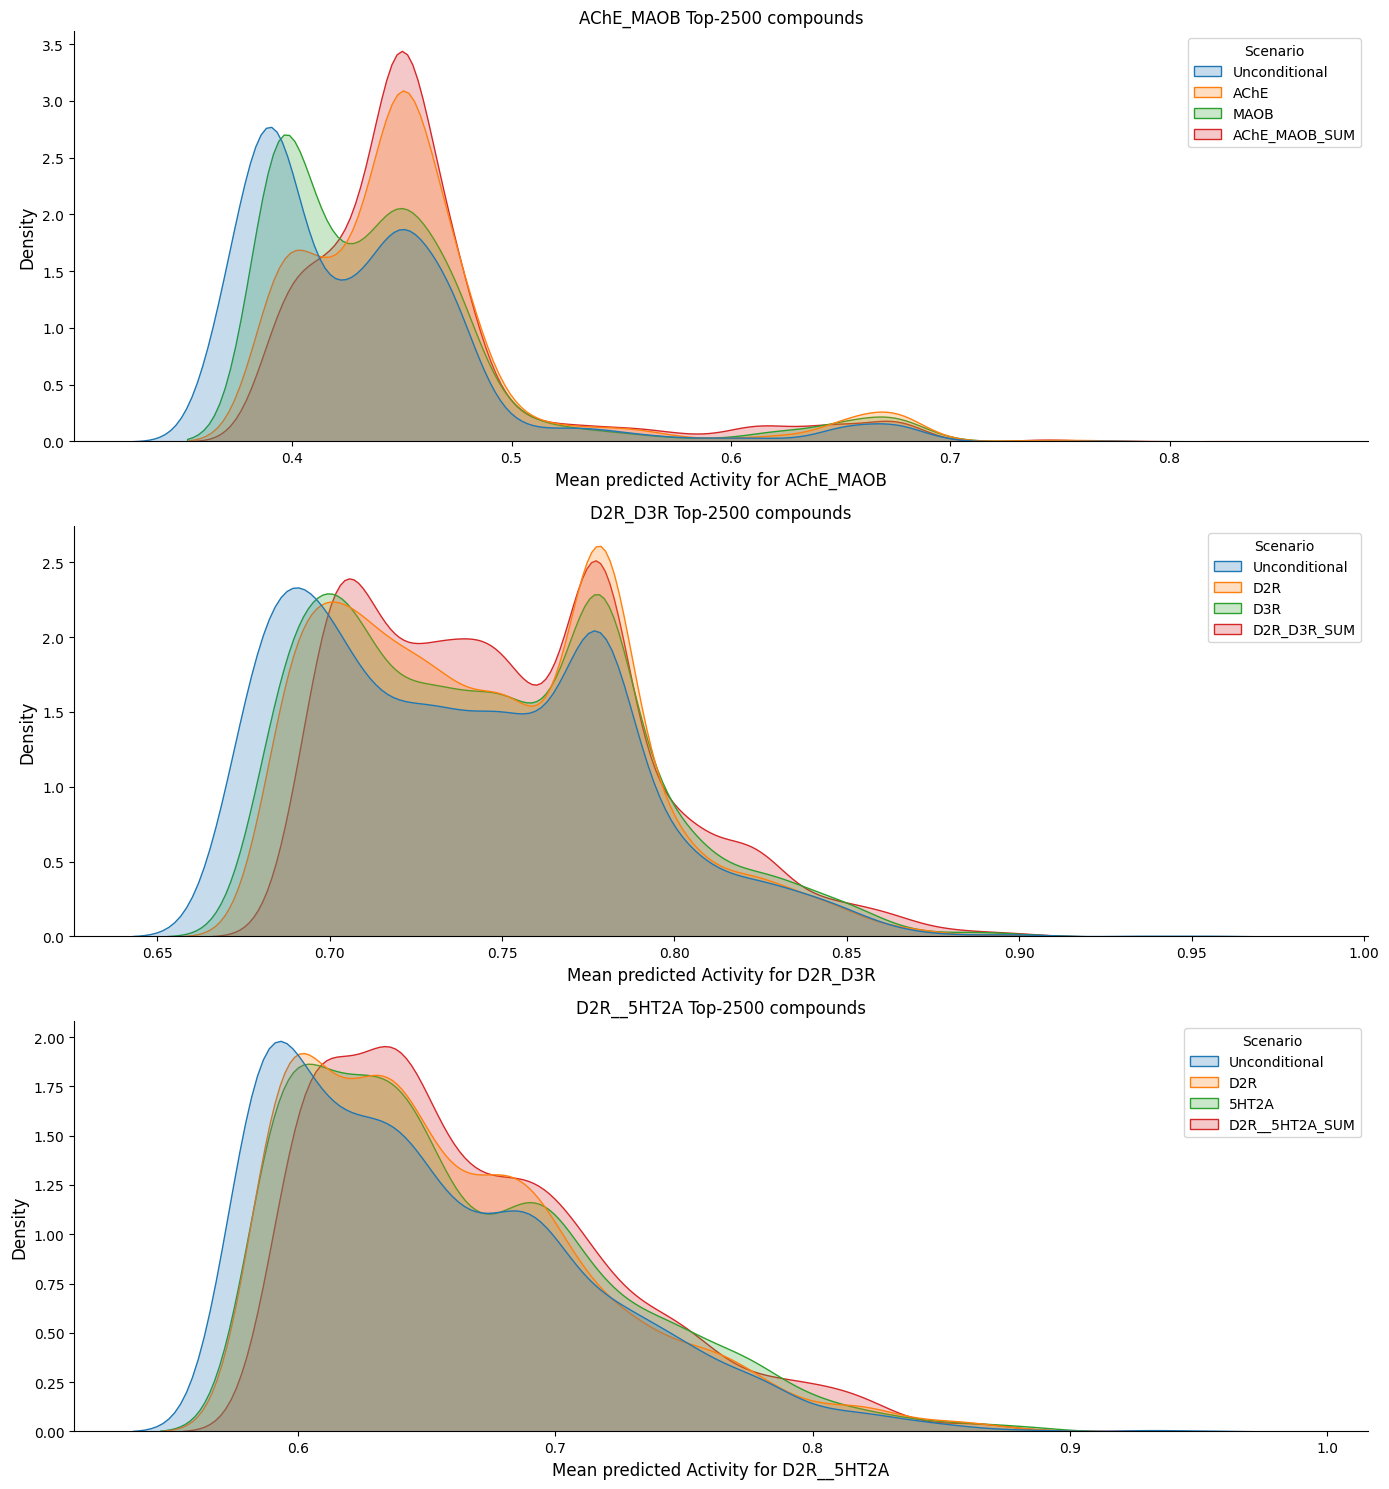

In [8]:
agg = "SUM"  # MEAN, MAX
ACT_TYPE = "Activity"  # pIC50, inhibition
# ACT_TYPE = "inhibition"  # pIC50, inhibition

multitarget_combination = {
    "AChE_MAOB": {
        "generated_molecules": ["Unconditional", "AChE", "MAOB", f"AChE_MAOB_{agg}"],
        # "generated_molecules": ["AChE", "MAOB", f"AChE_MAOB_{agg}"],
        "models": ["AChE", "MAOB"]
    },
    "D2R_D3R": {
        "generated_molecules": ["Unconditional", "D2R", "D3R", f"D2R_D3R_{agg}"],
        # "generated_molecules": [ "D2R", "D3R", f"D2R_D3R_{agg}"],
        "models": ["D2R", "D3R"]
    },
    "D2R__5HT2A": {
        "generated_molecules": ["Unconditional", "D2R", "_5HT2A", f"D2R__5HT2A_{agg}"],
        # "generated_molecules": [ "D2R", "_5HT2A", f"D2R__5HT2A_{agg}"],
        "models": ["D2R", "_5HT2A"]
    },
}

fig, axes = plt.subplots(len(multitarget_combination), 1, figsize=(14, 5 * len(multitarget_combination)))
n = 2500


for j, combination in enumerate(multitarget_combination):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()
    print(f"Combination: {activity_column}")

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        print(gen_molecule)
        # df = pd.read_csv(f'../generated_molecules/predicted_activity/{gen_molecule}_MTDD.csv')
        df = pd.read_csv(f'../generated_molecules/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        df_filtered = df[activity_column].nlargest(n).to_frame().assign(Scenario=scenario)
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()

    sns.kdeplot(data=activities, x=activity_column, bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)
    # sns.kdeplot(data=df, x="pred_pXC50", bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)

    axes[j].set_title('{} Top-{} compounds'.format(combination, n), fontsize=12)
    axes[j].spines['right'].set_visible(False)
    axes[j].spines['top'].set_visible(False)
    axes[j].set_ylabel("Density", fontsize=12)
    axes[j].set_xlabel(f"Mean predicted {ACT_TYPE} for {combination}", fontsize=12)

plt.tight_layout()
plt.show()

Combination: AChE_MAOB_Activity
Unconditional
AChE
MAOB
AChE_MAOB_SUM
Combination: D2R_D3R_Activity
Unconditional
D2R
D3R
D2R_D3R_SUM
Combination: D2R__5HT2A_Activity
Unconditional
D2R
_5HT2A
D2R__5HT2A_SUM


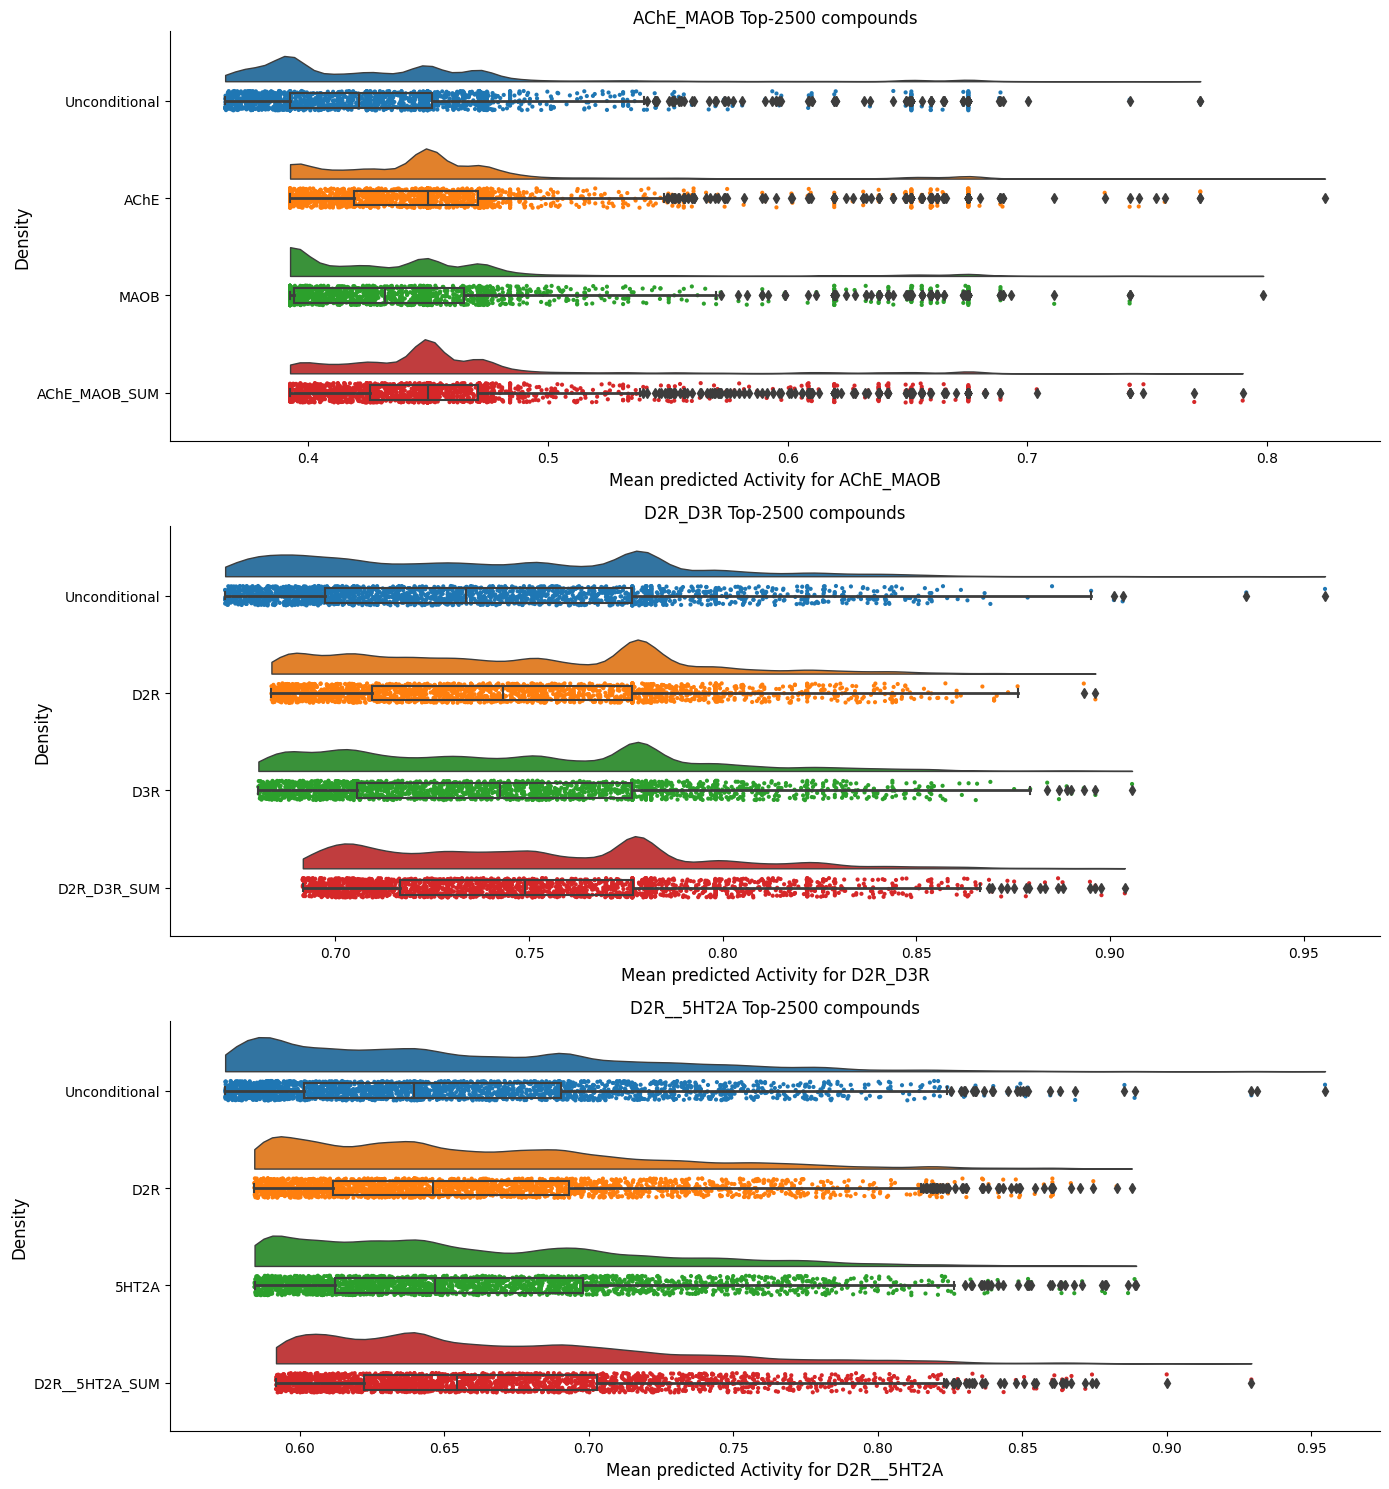

In [9]:
fig, axes = plt.subplots(len(multitarget_combination), 1, figsize=(14, 5 * len(multitarget_combination)))
n = 2500

for j, combination in enumerate(multitarget_combination):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()
    print(f"Combination: {activity_column}")

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        print(gen_molecule)
        # df = pd.read_csv(f'../generated_molecules/predicted_activity/{gen_molecule}_MTDD.csv')
        df = pd.read_csv(f'../generated_molecules/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        df_filtered = df[activity_column].nlargest(n).to_frame().assign(Scenario=scenario)
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()

    pt.RainCloud(data=activities, x='Scenario', y=activity_column, bw=.1, ax=axes[j], palette=pal, orient = "h")
    # sns.kdeplot(data=df, x="pred_pXC50", bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)

    axes[j].set_title('{} Top-{} compounds'.format(combination, n), fontsize=12)
    axes[j].spines['right'].set_visible(False)
    axes[j].spines['top'].set_visible(False)
    axes[j].set_ylabel("Density", fontsize=12)
    axes[j].set_xlabel(f"Mean predicted {ACT_TYPE} for {combination}", fontsize=12)

plt.tight_layout()
plt.show()

In [10]:
for j, combination in enumerate(multitarget_combination):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        df = pd.read_csv(f'../generated_molecules/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        df_filtered = df[activity_column].nlargest(n).to_frame().assign(Scenario=scenario)
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()
    pivot = activities.pivot_table(index='Scenario', values=activity_column, aggfunc=[np.mean, np.std])
    pivot = pivot.rename(columns={'mean': 'Mean', 'std': 'Std Deviation'})
    pivot = pivot.sort_values(by=('Mean', activity_column), ascending=False)

    format_str = "{:.2%}" if ACT_TYPE == "Activity" else "{:.2f}"
    # print(f"Combination: {combination}")
    display(pivot.style
                 .format(format_str)
                 .set_caption(f"Top-{n} {combination} {ACT_TYPE} statistics")
                 .background_gradient(cmap='Blues', axis=0))

,Mean,Std Deviation
,AChE_MAOB_Activity,AChE_MAOB_Activity
Scenario,,
AChE_MAOB_SUM,45.88%,5.94%
AChE,45.62%,6.30%
MAOB,44.49%,6.43%
Unconditional,43.18%,6.05%


,Mean,Std Deviation
,D2R_D3R_Activity,D2R_D3R_Activity
Scenario,,
D2R_D3R_SUM,75.22%,4.10%
D2R,74.57%,4.13%
D3R,74.52%,4.34%
Unconditional,73.80%,4.56%


,Mean,Std Deviation
,D2R__5HT2A_Activity,D2R__5HT2A_Activity
Scenario,,
D2R__5HT2A_SUM,66.78%,5.81%
5HT2A,66.14%,6.05%
D2R,65.94%,5.87%
Unconditional,65.23%,6.11%


In [11]:
# !pip install scipy

In [12]:
# Perform a T-test between the unconditional, target-specific, multitarget combinations
from scipy.stats import ttest_ind
from itertools import combinations

print("T-test results:")

for j, combination in enumerate(multitarget_combination):
    print()
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        df = pd.read_csv(f'../generated_molecules/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        df_filtered = df[activity_column].nlargest(n).to_frame().assign(Scenario=scenario)
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()

    # Use activities DF
    unique_scenarios = activities['Scenario'].unique()

    for scenario1, scenario2 in combinations(unique_scenarios, 2):
        scenario1_data = activities[activities['Scenario'] == scenario1]
        scenario2_data = activities[activities['Scenario'] == scenario2]

        t_stat, p_val = ttest_ind(scenario1_data[activity_column], scenario2_data[activity_column])
        print(f"{scenario1} vs {scenario2}: p-value = {p_val:.8f}")

T-test results:

Unconditional vs AChE: p-value = 0.00000000
Unconditional vs MAOB: p-value = 0.00000000
Unconditional vs AChE_MAOB_SUM: p-value = 0.00000000
AChE vs MAOB: p-value = 0.00000000
AChE vs AChE_MAOB_SUM: p-value = 0.14116924
MAOB vs AChE_MAOB_SUM: p-value = 0.00000000

Unconditional vs D2R: p-value = 0.00000000
Unconditional vs D3R: p-value = 0.00000001
Unconditional vs D2R_D3R_SUM: p-value = 0.00000000
D2R vs D3R: p-value = 0.66933935
D2R vs D2R_D3R_SUM: p-value = 0.00000003
D3R vs D2R_D3R_SUM: p-value = 0.00000001

Unconditional vs D2R: p-value = 0.00002844
Unconditional vs 5HT2A: p-value = 0.00000014
Unconditional vs D2R__5HT2A_SUM: p-value = 0.00000000
D2R vs 5HT2A: p-value = 0.24425365
D2R vs D2R__5HT2A_SUM: p-value = 0.00000038
5HT2A vs D2R__5HT2A_SUM: p-value = 0.00012717


### Data exploration and visualization

In [13]:
import sys
import torch
from collections import namedtuple

sys.path.append('../cMolGPT/')

from model_auto import Seq2SeqTransformer
from utils import read_delimited_file, read_csv_file
import vocabulary as mv

mol_list0_train = list(read_delimited_file('../data/train.smi'))
mol_list0_test = list(read_delimited_file('../data/test.smi'))

mol_list1, target_list = zip(*read_csv_file('../data/chembl_active_compounds.smi', num_fields=2))
mol_list = mol_list0_train
mol_list.extend(mol_list0_test) 
mol_list.extend(mol_list1)
vocabulary = mv.create_vocabulary(smiles_list=mol_list, tokenizer=mv.SMILESTokenizer())

BATCH_SIZE = 512
SRC_VOCAB_SIZE = len(vocabulary)
TGT_VOCAB_SIZE = len(vocabulary)

EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512

NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = DEVICE

args = namedtuple('args',['nhead'])(nhead=NHEAD)

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, 
                                EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                FFN_HID_DIM, args=args, emb_input_size=7)
transformer = transformer.to(device)
transformer.load_state_dict(torch.load('../models_cMolGPT/finetune.h5'))

<All keys matched successfully>

In [14]:
targets_to_idx = {
    "AChE": 1,
    "D2R": 2,
    # "D3R": 3,
    "_5HT2A": 4,
    "MAOB": 5,
}

target_to_key = {
    "AChE": torch.tensor([1]).to(device),
    "D2R": torch.tensor([2]).to(device),
    # "D3R": torch.tensor([3]).to(device),
    "_5HT2A": torch.tensor([4]).to(device),
    "MAOB": torch.tensor([5]).to(device),
}

target_embedding = dict()

for target in target_to_key:
    embedding = transformer.emb(target_to_key[target])
    target_embedding[target] = embedding

target_embedding["AChE"].shape

torch.Size([1, 512])

In [15]:
# compute the cosine similarity between the target embeddings
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

similarity = dict()

for target1 in target_embedding:
    for target2 in target_embedding:
        similarity[f"{target1}_{target2}"] = cos(target_embedding[target1], target_embedding[target2])

# similarity

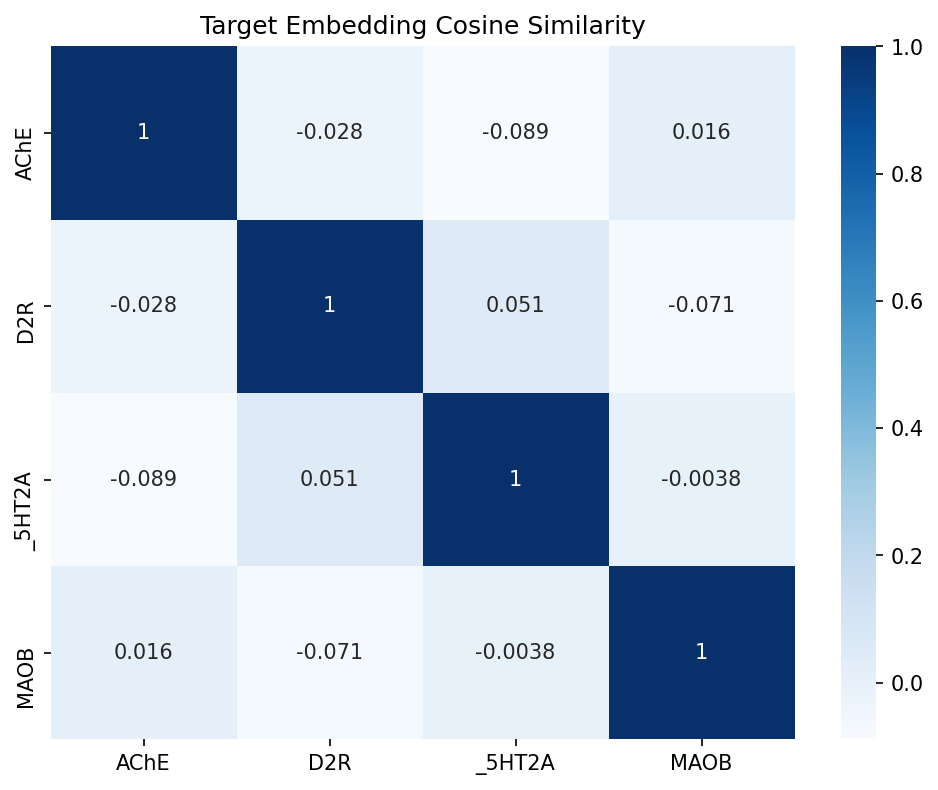

In [16]:
# plot the similarity matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

similarity_matrix = np.zeros((len(target_embedding), len(target_embedding)))

for i, target1 in enumerate(target_embedding):
    for j, target2 in enumerate(target_embedding):
        similarity_matrix[i, j] = similarity[f"{target1}_{target2}"].item()

plt.figure(figsize=(8, 6), dpi=150)

sns.heatmap(
    similarity_matrix, 
    annot=True, cmap='Blues',
    xticklabels=target_embedding.keys(), 
    yticklabels=target_embedding.keys()
)

plt.title('Target Embedding Cosine Similarity')

plt.show()

In [17]:
# egfr_sequence = """MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEV
# VLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALA
# VLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDF
# QNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGC
# TGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYV
# VTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFK
# NCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAF
# ENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKL
# FGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCN
# LLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVM
# GENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVV
# ALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGS
# GAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGI
# CLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAA
# RNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSY
# GVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPK
# FRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQ
# QGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTED
# SIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLN
# TVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRV
# APQSSEFIGA"""

# htr1a_sequence = """MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTLIFCAVLGNACVVAA
# IALERSLQNVANYLIGSLAVTDLMVSVLVLPMAALYQVLNKWTLGQVTCDLFIALDVLCC
# TSSILHLCAIALDRYWAITDPIDYVNKRTPRRAAALISLTWLIGFLISIPPMLGWRTPED
# RSDPDACTISKDHGYTIYSTFGAFYIPLLLMLVLYGRIFRAARFRIRKTVKKVEKTGADT
# RHGASPAPQPKKSVNGESGSRNWRLGVESKAGGALCANGAVRQGDDGAALEVIEVHRVGN
# SKEHLPLPSEAGPTPCAPASFERKNERNAEAKRKMALARERKTVKTLGIIMGTFILCWLP
# FFIVALVLPFCESSCHMPTLLGAIINWLGYSNSLLNPVIYAYFNKDFQNAFKKIIKCKFC
# RQ"""

# s1pr1_sequence = """MGPTSVPLVKAHRSSVSDYVNYDIIVRHYNYTGKLNISADKENSIKLTSVVFILICCFII
# LENIFVLLTIWKTKKFHRPMYYFIGNLALSDLLAGVAYTANLLLSGATTYKLTPAQWFLR
# EGSMFVALSASVFSLLAIAIERYITMLKMKLHNGSNNFRLFLLISACWVISLILGGLPIM
# GWNCISALSSCSTVLPLYHKHYILFCTTVFTLLLLSIVILYCRIYSLVRTRSRRLTFRKN
# ISKASRSSEKSLALLKTVIIVLSVFIACWAPLFILLLLDVGCKVKTCDILFRAEYFLVLA
# VLNSGTNPIIYTLTNKEMRRAFIRIMSCCKCPSGDSAGKFKRPIIAGMEFSRSKSDNSSH
# PQKDEGDNPETIMSSGNVNSSS"""

In [18]:
# from Bio.Seq import Seq
# from Bio.Align import PairwiseAligner

# egfr_seq = Seq(egfr_sequence.replace('\n', ''))
# htr1a_seq = Seq(htr1a_sequence.replace('\n', ''))
# s1pr1_seq = Seq(s1pr1_sequence.replace('\n', ''))

# targets_seq = {
#     "EGFR": egfr_seq,
#     "HTR1A": htr1a_seq,
#     "S1PR1": s1pr1_seq
# }

# egfr_seq

In [19]:
# aligner = PairwiseAligner()

# for target1 in targets_seq:
#     for target2 in targets_seq:
#         alignments = aligner.align(targets_seq[target1], targets_seq[target2])
#         best_alignment = alignments[0]

#         print(f"Alignment between {target1} and {target2}")
#         # print(best_alignment)

#         # Calculate sequence similarity as the fraction of identical residues
#         similarity = best_alignment.score / len(targets_seq[target1])

#         print(f"Similarity: {similarity:.2f}")

# # plot the similarity matrix
# similarity_matrix = np.zeros((3, 3))

# for i, target1 in enumerate(targets_seq):
#     for j, target2 in enumerate(targets_seq):
#         alignments = aligner.align(targets_seq[target1], targets_seq[target2])
#         best_alignment = alignments[0]

#         similarity_matrix[i, j] = best_alignment.score / len(targets_seq[target1])

# plt.figure(figsize=(8, 6), dpi=150)

# sns.heatmap(
#     similarity_matrix, 
#     annot=True, cmap='Blues',
#     xticklabels=targets_seq.keys(), 
#     yticklabels=targets_seq.keys()
# )

# plt.title('Target Protein Sequence Similarity')

# plt.show()

In [20]:
# from rdkit import RDLogger

# RDLogger.DisableLog('rdApp.*')

# import lightgbm as lgb
# from process_training_data import get_fp

# # load qsar models for each target
# targets = ["EGFR", "HTR1A", "S1PR1"]

# model = dict()

# for target in targets:
#     model[target] = lgb.Booster(model_file=f'./model/{target}.txt')

# # load active molecules dataset for each target
# active_molecules = dict()

# for target in targets:
#     X = np.load('npy/{}_X.npy'.format(target))
#     y = np.load('npy/{}_y.npy'.format(target))

#     print(X.shape, y.shape)

#     res = pd.DataFrame(X, columns=list(range(len(X[0]))))
#     res['activity'] = y

#     # res_active = res[res['activity'] >= 6.5]

#     active_molecules[target] = res

# # for each model, predict the activity of the active molecules datasets
# predicted_activities = dict()

# for target_model in targets:
#     predicted_activities[target_model] = dict()

#     for target_dataset in targets:
#         X = active_molecules[target_dataset].drop(columns=['activity']).values
#         y = active_molecules[target_dataset]['activity'].values

#         predicted_activities[target_model][target_dataset] = model[target_model].predict(X)

# # plot a scatter plot of the predicted activities for each target
# # each row is a target model, each column is a target dataset
# # the x axis is the predicted activity of the target model, the y axis is the predicted activity of the target dataset
# fig, axes = plt.subplots(3, 3, figsize=(14, 12))

# for i, target_model in enumerate(targets):
#     for j, target_dataset in enumerate(targets):
#         axes[i, j].scatter(
#             predicted_activities[target_model][target_dataset], 
#             active_molecules[target_dataset]['activity'], 
#             # predicted_activities[target_dataset][target_dataset],
#             alpha=0.3,
#             color=pal[i]
#         )

#         axes[i, j].set_title(f'{target_model} model vs {target_dataset} dataset')
#         axes[i, j].set_xlabel(f'{target_model} predicted activity (pXC50)')
#         axes[i, j].set_ylabel(f'{target_dataset} true activity (pXC50)')

#         # calculate the correlation coefficient
#         correlation = np.corrcoef(
#             predicted_activities[target_model][target_dataset], 
#             active_molecules[target_dataset]['activity']
#         )[0, 1]

#         axes[i, j].text(0.5, 0.9, f'Correlation: {correlation:.2f}', 
#                         horizontalalignment='center',
#                         verticalalignment='center',
#                         transform=axes[i, j].transAxes)


# plt.tight_layout()
# plt.show()

In [21]:
active_molecules_smiles = dict()
smiles_target = pd.read_csv("../data/chembl_active_compounds.smi", sep="\t", names=["SMILES", "target"])

targets_to_idx = {
    "AChE": 1,
    "D2R": 2,
    "D3R": 3,
    "_5HT2A": 4,
    "MAOB": 5,
}

for target in targets_to_idx:
    _id = targets_to_idx[target]
    smiles_target_id = smiles_target[smiles_target["target"] == _id]
    active_molecules_smiles[target] = smiles_target_id.sample(150)

active_molecules_smiles

{'AChE':                                                 SMILES  target
 76   O=C(Cc1c[nH]c2ccc(Br)cc12)NCCCCCCCNc1c2c(nc3cc...       1
 106  CC[N+](C)(CC)CCC[n+]1c(-c2ccccc2)c2cc(N)ccc2c2...       1
 261             COc1cccc2cc[n+](-c3ccccc3Br)cc12.[Br-]       1
 311        COc1cc2c(cc1CC=C(C)C)C(=O)CC(c1ccc(O)cc1)O2       1
 267  Cc1ccc(C2=CSC3=NC4=C(CNC/C4=C/c4ccc(Cl)cc4)C(c...       1
 ..                                                 ...     ...
 208            COc1cccc2c1C=[N+](c1ccc(I)cc1)CC2.[Br-]       1
 42   CC[N+](C)(CC)CCC[n+]1c(-c2ccccc2)c2cc(N)ccc2c2...       1
 132     COc1cc2c(cc1OC)C(=O)C(CC1CCN(Cc3ncccc3C)CC1)C2       1
 141  O=C1/C(=C/c2ccc(Br)cc2)CN(Cc2ccc3ccccc3c2)C/C1...       1
 9                COc1cccc2cc[n+](-c3ccccc3F)cc12.[Br-]       1
 
 [150 rows x 2 columns],
 'D2R':                                                 SMILES  target
 597  O=C1CCc2ccc(OCCCCN3CCN(c4cccc5c4ccn5S(=O)(=O)c...       2
 546  O=C(NCCN1CCC(O)(c2ccc(Cl)cc2)CC1)NCCN1C(=O)C=C...       

Text(0.5, 1.0, 'Tanimoto Similarity between Active Molecules Datasets')

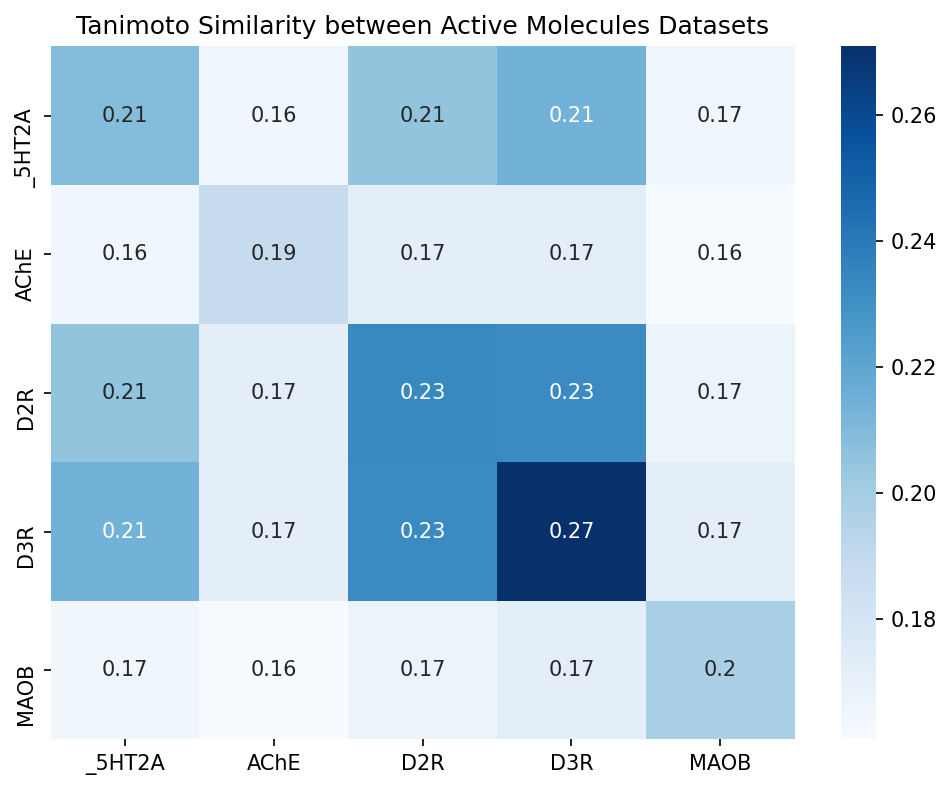

In [22]:
# import tanimoto bulk similarity
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmiles

# for each target, calculate the tanimoto similarity between the active molecules datasets
tanimoto_similarity = dict()

for target1 in targets:
    tanimoto_similarity[target1] = dict()

    for target2 in targets:
        tanimoto_similarity[target1][target2] = list()

        for smiles1 in active_molecules_smiles[target1]['SMILES']:
            mol1 = MolFromSmiles(smiles1)
            fp1 = AllChem.GetMorganFingerprint(mol1, 2)

            for smiles2 in active_molecules_smiles[target2]['SMILES']:
                mol2 = MolFromSmiles(smiles2)
                fp2 = AllChem.GetMorganFingerprint(mol2, 2)

                tanimoto_similarity[target1][target2].append(DataStructs.TanimotoSimilarity(fp1, fp2))

# plot the tanimoto similarity matrix
similarity_matrix = np.zeros((len(targets), len(targets)))

for i, target1 in enumerate(targets):
    for j, target2 in enumerate(targets):
        similarity_matrix[i, j] = np.mean(tanimoto_similarity[target1][target2])

plt.figure(figsize=(8, 6), dpi=150)

sns.heatmap(
    similarity_matrix, 
    annot=True, cmap='Blues',
    xticklabels=targets, 
    yticklabels=targets
)

plt.title('Tanimoto Similarity between Active Molecules Datasets')

#### Tree MAP

In [23]:
all_active_molecules = pd.DataFrame()

targets = ['_5HT2A', 'AChE', 'D2R', 'MAOB']
N = 800

for target in targets:
    mols_df = active_molecules_smiles[target]
    mols_df['target'] = target

    all_active_molecules = pd.concat([all_active_molecules, mols_df])

all_active_molecules

,SMILES,target
816,O=C(N[C@H]1CCN(Cc2cccc(C(F)(F)F)c2)C1)c1ccc(-c...,_5HT2A
882,Cc1cccc(N2CCN(CCCC(=O)NCn3nc(CC(N)=O)c4ccccc4c...,_5HT2A
1012,COc1ccc(/C=C2\NC(=O)N(CCCN3CCN(c4cccc(Cl)c4Cl)...,_5HT2A
948,CC(C)COc1ccc(CNC(=O)N(Cc2ccc(F)cc2)C2CCN(C(=O)...,_5HT2A
991,O=C(NC[C@@H]1[C@H]2CN(C(=O)OCc3cc(C(F)(F)F)cc(...,_5HT2A
...,...,...
1091,Cc1cccc(COc2ccc3c(c2)-c2nnc(C)cc2C3=O)c1,MAOB
1265,C#CCN(C)[C@H](C)Cc1ccccc1,MAOB
1196,Nc1nc(-c2ccccc2)c2c(n1)-c1cc(OCCCN3CCCC3)ccc1C2,MAOB
1140,Fc1ccc(-c2nc3ccc(N4CCCCC4)nc3s2)cc1,MAOB


In [24]:
for i, row in all_active_molecules.iterrows():
    print(row['SMILES'], row['target'])
    print(row)
    break

O=C(N[C@H]1CCN(Cc2cccc(C(F)(F)F)c2)C1)c1ccc(-c2cccs2)cc1 _5HT2A
SMILES    O=C(N[C@H]1CCN(Cc2cccc(C(F)(F)F)c2)C1)c1ccc(-c...
target                                               _5HT2A
Name: 816, dtype: object


In [25]:
training_mols = pd.read_csv(
    "../data/chembl_active_compounds.smi", sep="\t", names=["SMILES", "target"]
)
training_mols["target"] = training_mols["target"].replace(
    # {1: "EGFR", 2: "HTR1A", 3: "S1PR1"}
    {1: "AChE", 2: "D2R", 3: "D3R", 4: "_5HT2A", 5: "MAOB"}
)

targets = ["AChE", "D2R", "_5HT2A", "MAOB"]
ACT_TYPE = "Activity"

training_mols_ts = training_mols[training_mols["target"].isin(targets)]

for target in targets:
    transformers = pd.read_csv(f'../generated_molecules/predicted_activity/{target}.csv')

    smiles_top_500 = transformers.drop_duplicates(subset="SMILES").nlargest(N, f"{target}_{ACT_TYPE}")

    smiles_top_500['target'] = f"{target} (generated)"
    generated_mols = smiles_top_500[["SMILES", "target"]]

    training_mols_ts = pd.concat([training_mols_ts, generated_mols])

training_mols_ts["target"].value_counts()

AChE (generated)      800
D2R (generated)       800
_5HT2A (generated)    800
MAOB (generated)      800
AChE                  331
D2R                   289
MAOB                  250
_5HT2A                209
Name: target, dtype: int64

In [26]:
# add multi-target generated molecules
agg = "SUM"

multi_targets = [
    (f"AChE_MAOB_{agg}", "AChE", "MAOB"),
    (f"D2R__5HT2A_{agg}", "D2R", "_5HT2A"),
    # (f"D2R_D3R_{agg}", "D2R", "D3R")
]

training_mols_mt = training_mols_ts.copy()

for (mt, t1, t2) in multi_targets:
    transformers = pd.read_csv(f'../generated_molecules/predicted_activity/{mt}.csv')

    smiles_top_500 = transformers.drop_duplicates(subset="SMILES").nlargest(N, f"{t1}_{t2}_{ACT_TYPE}")

    smiles_top_500['target'] = f"{mt} (generated)"
    generated_mols = smiles_top_500[["SMILES", "target"]]

    training_mols_mt = pd.concat([training_mols_mt, generated_mols])

In [27]:
training_mols_mt["target"].value_counts()

AChE (generated)              800
D2R (generated)               800
_5HT2A (generated)            800
MAOB (generated)              800
AChE_MAOB_SUM (generated)     800
D2R__5HT2A_SUM (generated)    800
AChE                          331
D2R                           289
MAOB                          250
_5HT2A                        209
Name: target, dtype: int64

In [28]:
# !conda install -c tmap tmap -y
# !pip install faerun mhfp

In [29]:
import numpy as np
import tmap as tm
import scipy.stats as ss
from rdkit.Chem import AllChem
from mhfp.encoder import MHFPEncoder
from faerun import Faerun
from matplotlib.colors import ListedColormap


filter_types = [
    "AChE",
    "MAOB",
    "AChE (generated)",
    "MAOB (generated)",
    "AChE_MAOB_SUM (generated)",
    # "D2R",
    # "_5HT2A",
    # "D2R (generated)",
    # "_5HT2A (generated)",
    # "D2R__5HT2A_SUM (generated)",
]

colors = {
    "AChE": "lightgreen",
    "AChE (generated)": "darkgreen",
    "D2R": "orange",
    "D2R (generated)": "darkorange",
    "_5HT2A": "blue",
    "_5HT2A (generated)": "darkblue",
    "MAOB": "#ff9a98", # "lightred",
    "MAOB (generated)": "darkred",
    "AChE_MAOB_SUM (generated)": "yellow",
    "D2R__5HT2A_SUM (generated)": "brown",
}

def main():
    """ Main funciton """
    # df = all_active_molecules
    df = training_mols_mt.query("target in @filter_types")

    enc = MHFPEncoder(1024)
    lf = tm.LSHForest(1024, 64)

    fps = []
    hac = []
    c_frac = []
    ring_atom_frac = []
    largest_ring_size = []

    for i, row in df.iterrows():
        if i != 0 and i % 1000 == 0:
            print(f"{i / len(df):0.2%} done")
        mol = AllChem.MolFromSmiles(row["SMILES"])
        atoms = mol.GetAtoms()
        size = mol.GetNumHeavyAtoms()
        n_c = 0
        n_ring_atoms = 0
        for atom in atoms:
            if atom.IsInRing():
                n_ring_atoms += 1
            if atom.GetSymbol().lower() == "c":
                n_c += 1

        c_frac.append(n_c / size)
        ring_atom_frac.append(n_ring_atoms / size)
        sssr = AllChem.GetSymmSSSR(mol)
        if len(sssr) > 0:
            largest_ring_size.append(max([len(s) for s in sssr]))
        else:
            largest_ring_size.append(0)
        hac.append(size)
        fps.append(tm.VectorUint(enc.encode_mol(mol)))

    lf.batch_add(fps)
    lf.index()

    c_frak_ranked = ss.rankdata(np.array(c_frac) / max(c_frac)) / len(c_frac)

    cfg = tm.LayoutConfiguration()
    cfg.node_size = 1 / 26
    cfg.mmm_repeats = 2
    cfg.sl_extra_scaling_steps = 5
    cfg.k = 20
    cfg.sl_scaling_type = tm.RelativeToAvgLength
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

    type_labels, type_data = Faerun.create_categories(df["target"])

    cmap = ListedColormap([colors[t[1]] for t in type_labels])

    f = Faerun(view="front", coords=False)
    f.add_scatter(
        "np_atlas",
        {
            "x": x,
            "y": y,
            "c": [
                type_data,
            ],
            "labels": df["SMILES"],
        },
        shader="smoothCircle",
        point_scale=2.0,
        max_point_size=20,
        legend_labels=[type_labels],
        categorical=[True],
        colormap=[cmap],
        series_title=[
            "Type",
        ],
        has_legend=True,
    )
    f.add_tree("np_atlas_tree", {"from": s, "to": t}, point_helper="np_atlas")
    f.plot(template="smiles")

main()

234.82% done
972.83% done
503.19% done


/home/arthurcerveira/miniconda3/envs/aidd/lib/python3.9/site-packages/mhfp/encoder.py:297: UserWarning: The length of the shingling is 0, which results in an empty set and an all zero folded fingerprint.
  warnings.warn("The length of the shingling is 0, which results in an empty set and an all zero folded fingerprint.")


/home/arthurcerveira/cMolGPT-Brain-Diseases/scripts/index.html

In [30]:
type_labels, type_data = Faerun.create_categories(training_mols["target"])
type_labels

[(0, 'AChE'), (1, 'D2R'), (2, 'D3R'), (3, 'MAOB'), (4, '_5HT2A')]